In [98]:
import cdsapi
import pandas
import matplotlib.pyplot as plt
import datetime
import xarray as xr
import cfgrib
import statsmodels.api as sm
import seaborn as sns
import itertools

sns.set()

## **Conectando com a API de dados**

In [6]:
c = cdsapi.Client()

Exception: Missing/incomplete configuration file: C:\Users\bernardo.costa/.cdsapirc

In [9]:
days = [str(i).zfill(2) for i in range(1, 32)]
months = [str(i).zfill(2) for i in range(1, 13)]
years = [str(i) for i in range(2000, 2023)]
time = [str(i).zfill(2) + ':00' for i in range(0, 24, 4)]
area =  [6, -176, -34, -35]  # North, East, South, West

In [12]:
c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'grib',
        'month': months,
        'year': years,
        'day': days,
        'time': time,
        'variable': '2m_temperature',
        'area': area
    },
    'download.grib'
)

2023-11-22 21:39:33,648 INFO Welcome to the CDS
2023-11-22 21:39:33,649 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-22 21:39:33,902 INFO Request is queued
2023-11-22 22:52:35,084 INFO Request is running
2023-11-22 23:28:56,050 INFO Request is completed
2023-11-22 23:28:56,051 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data3/adaptor.mars.internal-1700704005.9385033-2432-7-be72d764-e461-4be6-907f-6ce915f49de7.grib to download.grib (8.5G)
2023-11-23 00:04:12,021 INFO Download rate 4.1M/s      


Result(content_length=9175908240,content_type=application/x-grib,location=https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data3/adaptor.mars.internal-1700704005.9385033-2432-7-be72d764-e461-4be6-907f-6ce915f49de7.grib)

## **Encontrar cidades grandes do Brasil**

### **Dados das cidades**
- Encontrar as latitudes e longitudes das principais cidades brasileiras: rio, salvador, brasilia, bh, são paulo, manaus
- Encontrar a temperatura da cidade com base na latitude e longitude
  - **Série temporal de 2000 - 2023, de 4 em 4 horas, para todos os dias, da temperatura da cidade**

### **Dados do El Niño**

- Encontrar a latitude e longitude do El Niño
- Calcular a média das temperaturas na região do El Niño
  - **Série temporal de 2000 - 2032, de 4 em 4 horas, para todos os dias, da temperatura na região do El niño**

### **Obtendo dados de São Paulo**

In [23]:
c = cdsapi.Client()

In [24]:
days = [str(i).zfill(2) for i in range(1, 32)]
months = [str(i).zfill(2) for i in range(1, 13)]
years = [str(i) for i in range(2000, 2023)]
time = [str(i).zfill(2) + ':00' for i in range(0, 24, 4)]
area = [-23, -47, -24, -45]

In [25]:
c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'grib',
        'month': months,
        'year': years,
        'day': days,
        'time': time,
        'variable': '2m_temperature',
        'area': area
    },
    'download_sao_paulo.grib'
)

2023-11-23 20:35:45,303 INFO Welcome to the CDS
2023-11-23 20:35:45,304 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-23 20:35:45,593 INFO Request is completed
2023-11-23 20:35:45,594 INFO Downloading https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data7/adaptor.mars.internal-1700778255.0761623-8851-1-522a20ad-b3dd-49aa-bda0-8d8719ffd8df.grib to download_sao_paulo.grib (11.5M)
2023-11-23 20:35:54,257 INFO Download rate 1.3M/s   


Result(content_length=12097440,content_type=application/x-grib,location=https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data7/adaptor.mars.internal-1700778255.0761623-8851-1-522a20ad-b3dd-49aa-bda0-8d8719ffd8df.grib)

In [7]:
# Load the GRIB file
ds = xr.open_dataset('download_sao_paulo.grib', engine='cfgrib')

print(ds)

# Access a specific variable
temperature = ds['t2m']
print(temperature)

c:\Users\bernardo.costa\Documents\personal\ia4good\AI4GOOD\venv\lib\site-packages\gribapi\__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.27.0
  warnings.warn(


<xarray.Dataset>
Dimensions:     (time: 50406, latitude: 5, longitude: 9)
Coordinates:
    number      int32 ...
  * time        (time) datetime64[ns] 2000-01-01 ... 2022-12-31T20:00:00
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 -23.0 -23.25 -23.5 -23.75 -24.0
  * longitude   (longitude) float64 -47.0 -46.75 -46.5 ... -45.5 -45.25 -45.0
    valid_time  (time) datetime64[ns] ...
Data variables:
    t2m         (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-11-25T15:07 GRIB to CDM+CF via cfgrib-0.9.1...
<xarray.DataArray 't2m' (time: 50406, latitude: 5, longitude: 9)>
[2268270 values with dtype=float32]
Coor

In [8]:
sao_paulo = temperature.where(temperature.latitude - (-23.533773) + temperature.longitude - (-46.625290) < 0.01)

In [9]:
df = sao_paulo.to_dataframe().reset_index()

In [10]:
df_sao_paulo_temperatures = df[df['t2m'].notna()]

In [72]:
df_sao_paulo_temperatures = df_sao_paulo_temperatures.groupby('time').agg({'t2m': 'mean'}).reset_index()

In [73]:
df_sao_paulo_temperatures

,time,t2m
0,2000-01-01 00:00:00,295.405792
1,2000-01-01 04:00:00,294.166840
2,2000-01-01 08:00:00,294.208496
3,2000-01-01 12:00:00,295.512909
4,2000-01-01 16:00:00,296.298340
...,...,...
50401,2022-12-31 04:00:00,293.031555
50402,2022-12-31 08:00:00,292.620880
50403,2022-12-31 12:00:00,295.308746
50404,2022-12-31 16:00:00,298.525208


## **Análises de Séries Temporais**

- Verificar estacionariedade
- Verificar sazonalidade
- Computar o ACF (Autocorrelation Function) e PACF (Partial Autocorrelation Function)

In [109]:
analysis_df = df_sao_paulo_temperatures.loc[df_sao_paulo_temperatures['time'].dt.date > datetime.date(year=2020, month=1, day=1)]
analysis_df = analysis_df.set_index('time')

In [153]:
mean_daily_temperatures = df_sao_paulo_temperatures.groupby(pandas.Grouper(key='time', freq='1D')).mean()
mean_month_temperatures = df_sao_paulo_temperatures.groupby(pandas.Grouper(key='time', freq='1M')).mean()

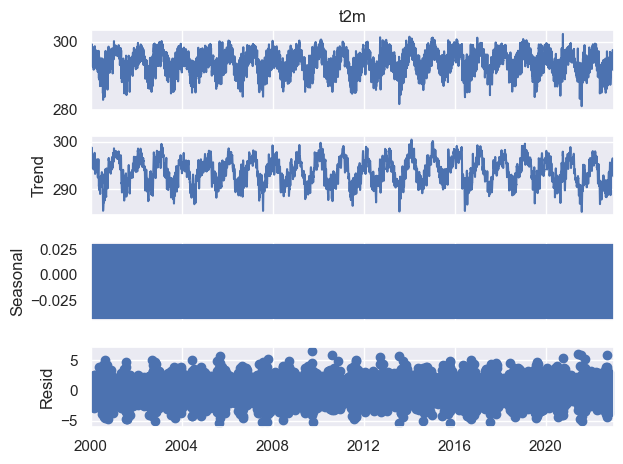

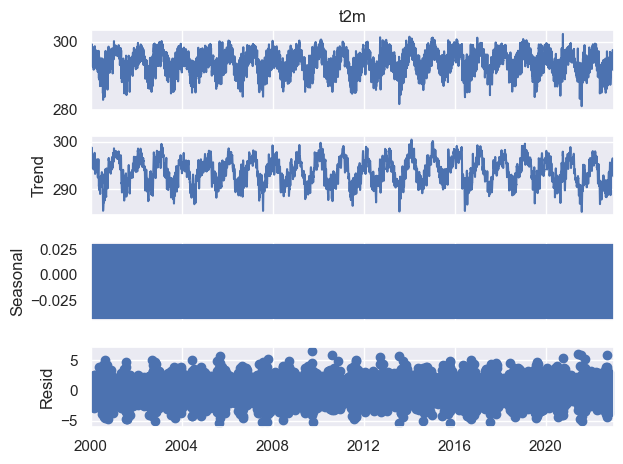

In [154]:
decomposition = sm.tsa.seasonal_decompose(mean_daily_temperatures['t2m'], model='additive')
decomposition.plot()

In [121]:
result = sm.tsa.stattools.adfuller(mean_daily_temperatures.t2m)
print('ADF Statistic on the entire dataset: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic on the entire dataset: -7.342984933214516
p-value: 1.0532595347536064e-10
Critical Values:
	1%: -3.4311306784190343
	5%: -2.8618850060724674
	10%: -2.5669536418716876


In [120]:
result = sm.tsa.stattools.adfuller(mean_month_temperatures.t2m)
print('ADF Statistic on the entire dataset: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic on the entire dataset: -2.845544375036321
p-value: 0.05205680561988447
Critical Values:
	1%: -3.4557539868570775
	5%: -2.8727214497041422
	10%: -2.572728476331361


In [119]:
result = sm.tsa.stattools.adfuller(df_sao_paulo_temperatures.t2m)
print('ADF Statistic on the entire dataset: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic on the entire dataset: -12.727366425365373
p-value: 9.537747041605517e-24
Critical Values:
	1%: -3.4304798886436574
	5%: -2.8615974081216833
	10%: -2.5668005564429905


In [129]:
result = sm.tsa.stattools.adfuller(analysis_df.t2m)
print('ADF Statistic on the entire dataset: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic on the entire dataset: -6.1446688250012444
p-value: 7.819381913789089e-08
Critical Values:
	1%: -3.4313510513374808
	5%: -2.8619823793165287
	10%: -2.567005475109308


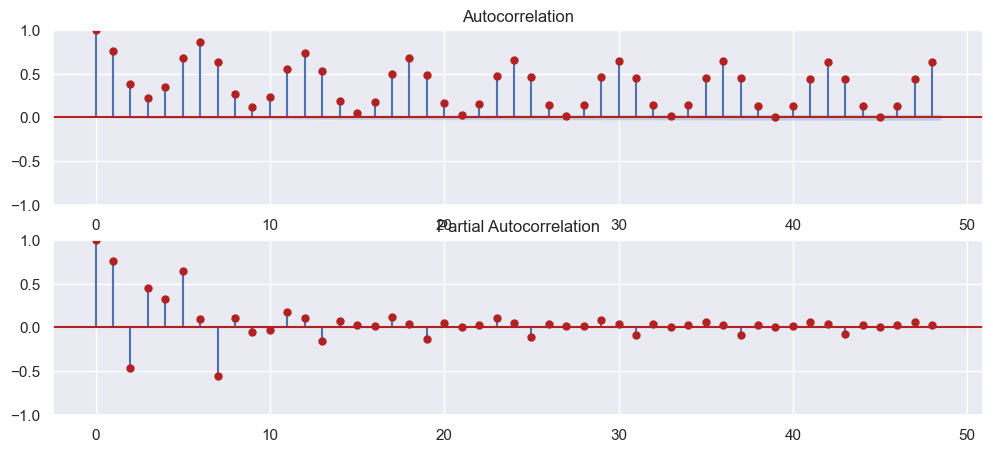

In [126]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_sao_paulo_temperatures.t2m, ax=ax1,color ='firebrick')
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_sao_paulo_temperatures.t2m, ax=ax2,color='firebrick')

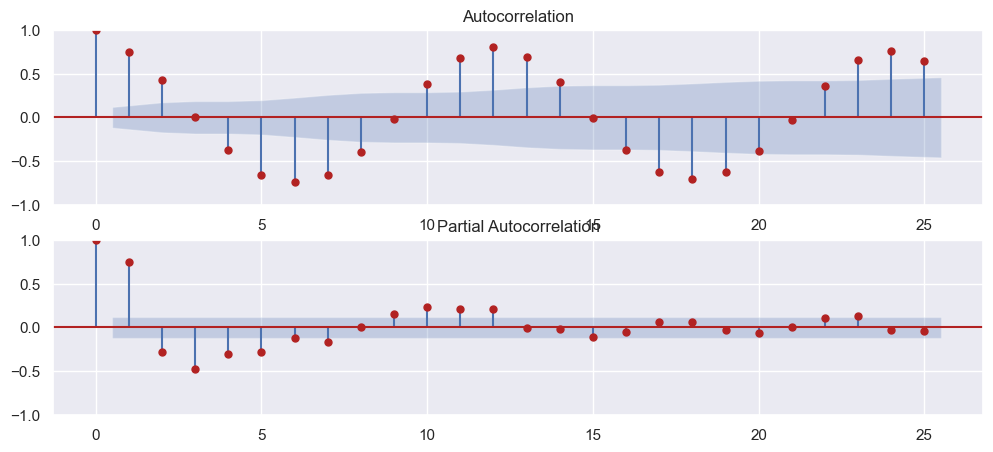

In [127]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(mean_month_temperatures.t2m, ax=ax1,color ='firebrick')
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(mean_month_temperatures.t2m, ax=ax2,color='firebrick')

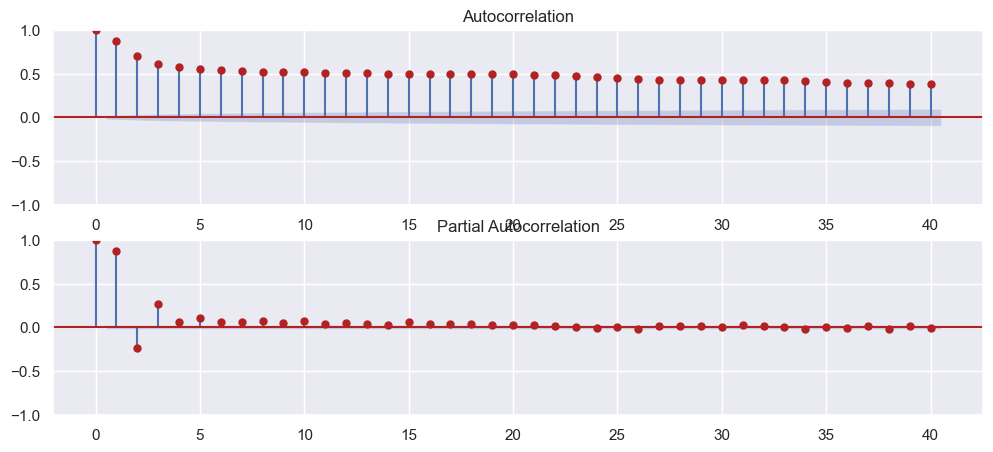

In [125]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(mean_daily_temperatures.t2m, ax=ax1,color ='firebrick')
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(mean_daily_temperatures.t2m, ax=ax2,color='firebrick')

## **ML**

### **Primeiro passo**

Utilizar modelos de Série Temporal para prever a temperatura de uma cidade com base exclusivamente na temperatura histórica de cada cidade.

In [143]:
def split_data(dataframe: pandas.DataFrame, test_split: float) -> tuple[pandas.DataFrame, pandas.DataFrame]:
    train_max_id = int(dataframe.shape[0] * (1 - test_split))
    train_data = dataframe.iloc[:train_max_id]
    test_data  = dataframe.iloc[train_max_id:]

    return train_data, test_data

In [192]:
train_data, test_data = split_data(mean_month_temperatures, test_split=0.1)

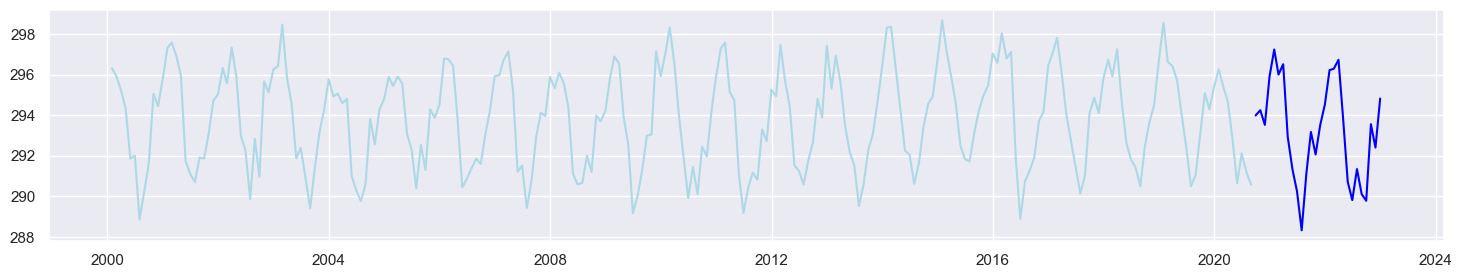

In [193]:
figure = plt.figure(figsize=(18,3))
plt.plot(train_data['t2m'], c='lightblue')
plt.plot(test_data['t2m'], c='blue')
plt.show()

In [194]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

In [196]:
train_data.shape[0] * 0.5

124.0

In [197]:
forecaster = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123), lags=12)

# Lags used as predictors
lags_grid = [2, 15]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train_data.t2m,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = test_data.shape[0],
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(train_data.shape[0] * 0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
)

Number of models compared: 12.


lags grid: 100%|██████████| 2/2 [01:06<00:00, 33.33s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
  Parameters: {'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 1.4818275352650423



In [198]:
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",1.481828,5,500
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",1.494598,3,500
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",1.509536,10,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",1.516345,10,100
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",1.516608,5,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",1.542150,3,100
1,"[1, 2]","{'max_depth': 3, 'n_estimators': 500}",7.683401,3,500
0,"[1, 2]","{'max_depth': 3, 'n_estimators': 100}",7.847466,3,100
5,"[1, 2]","{'max_depth': 10, 'n_estimators': 500}",8.012595,10,500
4,"[1, 2]","{'max_depth': 10, 'n_estimators': 100}",8.813841,10,100


In [202]:
max_depth, n_estimators = results_grid[results_grid['mean_squared_error'] == results_grid['mean_squared_error'].min()][['max_depth','n_estimators']].iloc[0]

In [204]:
regressor = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=123)
forecaster = ForecasterAutoreg(regressor=regressor, lags=15)

forecaster.fit(y=train_data.t2m)

In [205]:
predictions = forecaster.predict(steps=test_data.shape[0])

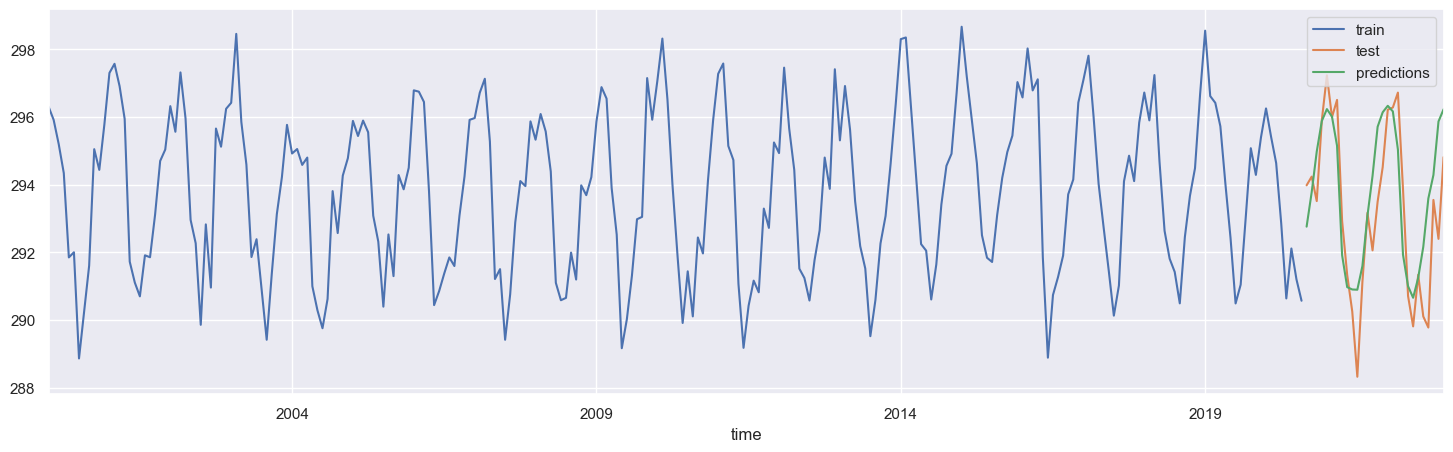

In [206]:
fig, ax = plt.subplots(figsize=(18, 5))
train_data.t2m.plot(ax=ax, label='train')
test_data.t2m.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### **Unindo os dados**

Utilizar modelos de Série Temporal multi-variado para agregar as informações da série temporal da cidade e a série temporal histórica do El Niño, para prever a temperatura de cada cidade.

- pegar os dados do el nino
- utilizar o skforecast com os dados de sp + el nino
- verificar se o predict é melhor do que com apenas os dados da temperatura da cidade

## **Possíveis conclusões**

- Iremos observar se é possível utilizar os dados históricos do El Niño para agregar como feature para a predição da temperatura de cidades brasileiras
- Rankear as cidades em que a previsão da temperatura foi impactada positivamente pelo utilização dessa outra série temporal